## Compute Sagnac Frequency - Backscatter Correction

## Imports

In [59]:
import os
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read
from scipy.signal import hilbert


from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from acoustics.signal import phase_spectrum, angle_spectrum

In [7]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [22]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

config['tbeg'] = UTCDateTime("2023-09-19 00:00")
config['tend'] = UTCDateTime("2023-09-19 10:00")

# config['f_lower_zoomin'], config['f_upper_zoomin'] = 448-10, 448+10

config['path_to_data'] = archive_path+f"romy_autodata/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [9]:
def __load_romy_raw_data(seeds, tbeg, tend, path_to_sds):

    from andbro__read_sds import __read_sds
    from obspy import Stream, UTCDateTime

    st0 = Stream()

    for seed in seeds:

        print(f" -> loading {seed}...")

        try:
            st00 = __read_sds(path_to_sds, seed, tbeg,tend, data_format='MSEED')
        except:
            print(f" -> failed for {seed}")

        st0 += st00

    st0 = st0.sort()

    for tr in st0:
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

    return st0

In [10]:
def __get_values(ff, psd, fph, ph, f_sagn):

    from numpy import argmax, sqrt, where, argmin
    from acoustics.signal import phase_spectrum

    ## specify f-band around Sagnac frequency
    fl = f_sagn-2
    fu = f_sagn+2

    ## get index of Sagnac peak
    idx_fs = where(psd == max(psd[(ff > fl) & (ff < fu)]))[0][0]

    ## estimate Sagnac frequency
    f_sagn_est = ff[idx_fs]

    ## estimate AC value at Sagnac peak
    # AC_est = max(psd[(ff > fl) & (ff < fu)])
    AC_est = psd[idx_fs]

    ## estimate DC value at ff = 0
    DC_est = psd[0]

    ## estimate phase at Sagnac peak
    idx_ph = argmin(abs(fph- f_sagn_est)) ## finde index of phase closest to sagnac frequency
    phase_est = ph[idx_ph] ## select phase of Sagnac

    return f_sagn_est, sqrt(AC_est), sqrt(DC_est), phase_est

## NEW ULLI

In [160]:
sagn = read(root_path+"Downloads/mseed/30min/DROMY_FJU_2023-09-19.mseed").trim(config['tbeg'], config['tbeg']+300)
mon1 = read(root_path+"Downloads/mseed/30min/DROMY_F1V_2023-09-19.mseed").trim(config['tbeg'], config['tbeg']+300)
mon2 = read(root_path+"Downloads/mseed/30min/DROMY_F2V_2023-09-19.mseed").trim(config['tbeg'], config['tbeg']+300)

In [161]:
for tr in sagn:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon1:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon2:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

In [162]:
# sagn.interpolate(20000);
# mon1.interpolate(20000);
# mon2.interpolate(20000);

In [163]:
# sagn.plot();
# mon1.plot();
# mon2.plot();

## Processing

In [164]:
f_m, psd_m = __multitaper_psd(mon1[0].data, mon1[0].stats.delta, n_win=5)

DPSS using interpolation 1500001 1000000


In [165]:
f_w, psd_w = __welch_psd(mon1[0].data, mon1[0].stats.delta, twin_sec=300)

In [166]:
f_pha, pha = phase_spectrum(mon1[0].data, mon1[0].stats.sampling_rate)

In [167]:
fs_w, ac_w, dc_w, ph_w = __get_values(f_w, psd_w, f_pha, pha, 303)

In [168]:
fs_m, ac_m, dc_m, ph_m = __get_values(f_m, psd_m, f_pha, pha, 303)

In [169]:
f_pha1, pha1 = phase_spectrum(mon1[0].data, mon1[0].stats.sampling_rate)
f_pha2, pha2 = phase_spectrum(mon2[0].data, mon2[0].stats.sampling_rate)
f_pha, pha = phase_spectrum(sagn[0].data, sagn[0].stats.sampling_rate)

(-1000.0, 100.0)

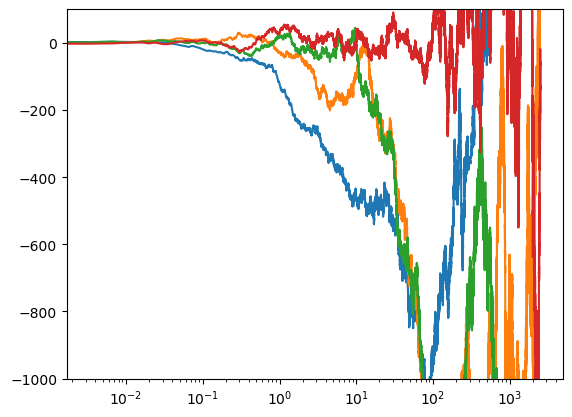

In [170]:
plt.semilogx(f_pha, pha)
plt.semilogx(f_pha1, pha1)
plt.semilogx(f_pha2, pha2)

plt.semilogx(f_pha2, np.unwrap(pha1-pha2))
plt.ylim(-1000, 100)

In [171]:
from scipy.fftpack import fft
import numpy as np

phase0 = np.unwrap(np.angle(fft(sagn[0].data)))
phase1 = np.unwrap(np.angle(fft(mon1[0].data)))
phase2 = np.unwrap(np.angle(fft(mon2[0].data)))


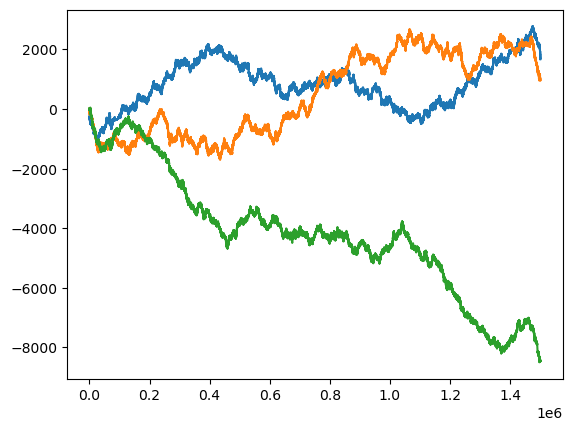

In [172]:
plt.plot(phase0)
plt.plot(phase1)
plt.plot(phase2)

## Plotting

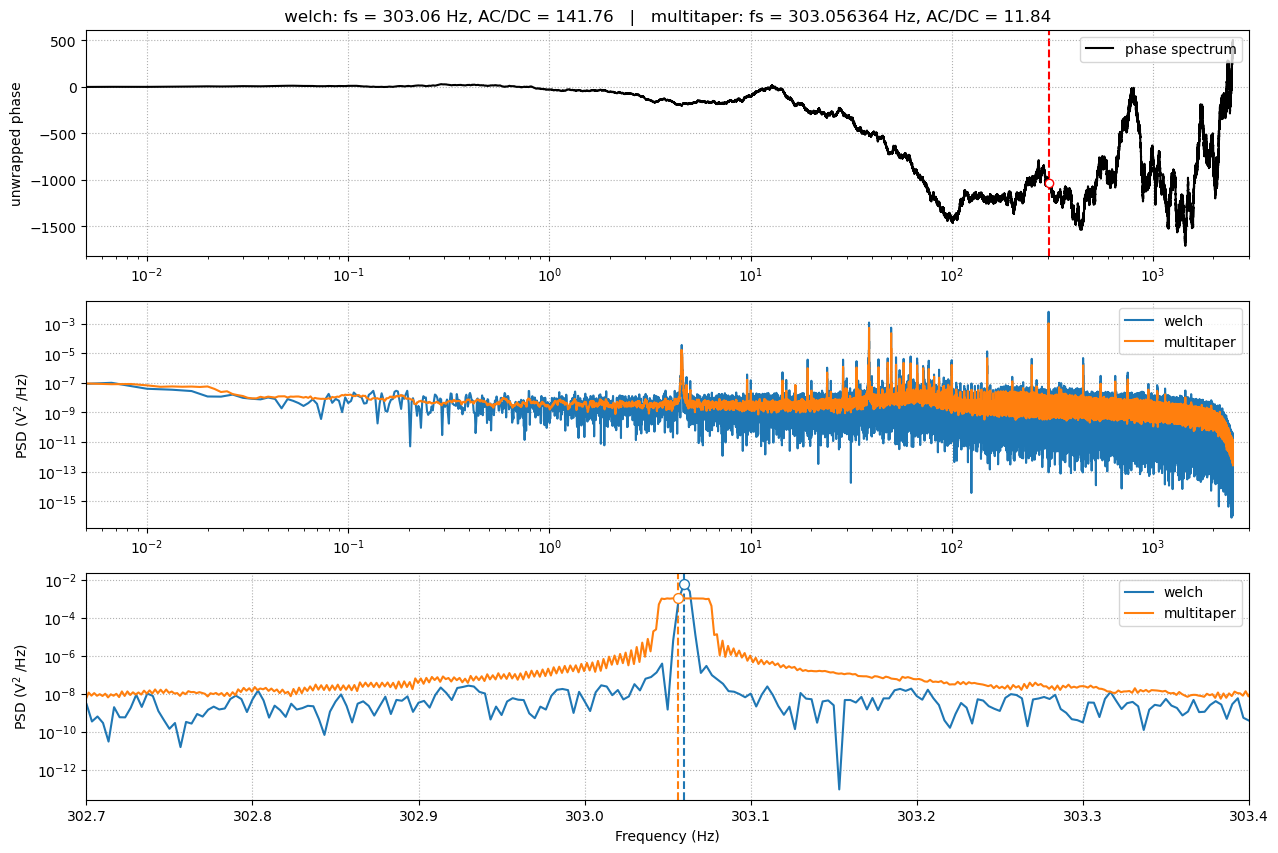

In [173]:
def __makeplot():

    Nrow = 3

    fig, ax = plt.subplots(Nrow, 1, figsize=(15, 10))

    ax[0].semilogx(f_pha1, pha1, color="k", label="phase spectrum")
    ax[0].scatter(fs_w, ph_w, color="w", edgecolor="r", zorder=2)
    ax[0].axvline(fs_w,  color="r", ls="--", zorder=1)


    ax[1].loglog(f_w, psd_w, label="welch")
    ax[1].loglog(f_m, psd_m, label="multitaper")

    ax[2].semilogy(f_w[(f_w > 300) & (f_w < 304)], psd_w[(f_w > 300) & (f_w < 304)], label="welch")
    ax[2].semilogy(f_m[(f_m > 300) & (f_m < 304)], psd_m[(f_m > 300) & (f_m < 304)], label="multitaper")

    ax[2].scatter(fs_w, ac_w**2, s=50, color="white", edgecolors="tab:blue", zorder=2)
    ax[2].scatter(fs_m, ac_m**2, s=50, color="white", edgecolor="tab:orange", zorder=2)

    ax[2].axvline(fs_w,  color="tab:blue", ls="--", zorder=1)
    ax[2].axvline(fs_m, color="tab:orange", ls="--", zorder=1)

    for i in range(Nrow):
        ax[i].grid(ls=":", zorder=0)
        ax[i].legend(loc=1)

    ax[2].set_xlim(302.7, 303.4)

    ax[0].set_xlim(5e-3, 3e3)
    ax[1].set_xlim(5e-3, 3e3)

    # ax[1].set_xlabel("Frequency (Hz)")
    ax[2].set_xlabel("Frequency (Hz)")

    ax[0].set_ylabel("unwrapped phase")
    ax[1].set_ylabel("PSD (V$^2$ /Hz)")
    ax[2].set_ylabel("PSD (V$^2$ /Hz)")

    ac_dc_w = np.sqrt( ac_w / dc_w )
    ac_dc_m = np.sqrt( ac_m / dc_m )

    title_m = f"multitaper: fs = {round(fs_m,6)} Hz, AC/DC = {round(ac_dc_m,2)}"
    title_w = f"welch: fs = {round(fs_w,6)} Hz, AC/DC = {round(ac_dc_w,2)}"
    ax[0].set_title(f" {title_w}   |   {title_m} ")

    plt.show();
    return fig

fig = __makeplot()

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_compare_welch_multitaper.jpeg", format="jpeg", dpi=200, bbox_inches='tight')

## Automatic

In [117]:
sagn = read(root_path+"Downloads/mseed/DROMY_FJU_2023-09-19.mseed").trim(config['tbeg'], config['tend'])
mon1 = read(root_path+"Downloads/mseed/DROMY_F1V_2023-09-19.mseed").trim(config['tbeg'], config['tend'])
mon2 = read(root_path+"Downloads/mseed/DROMY_F2V_2023-09-19.mseed").trim(config['tbeg'], config['tend'])

In [118]:
for tr in sagn:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon1:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]
for tr in mon2:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]


In [119]:
from functions.get_time_intervals import __get_time_intervals

In [122]:
tbeg, tend = sagn[0].stats.starttime, sagn[0].stats.endtime

interval = 180 ## seconds

times = __get_time_intervals(tbeg, tend, interval_seconds=interval, interval_overlap=0)

In [123]:
fs_w, ac_w, dc_w, ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan
fs_m, ac_m, dc_m, ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan

for _n, (t1, t2) in enumerate(times):

    _dat = sagn.copy().trim(t1, t2)

    f_w, psd_w = __welch_psd(_dat[0].data, _dat[0].stats.delta, twin_sec=60)
    f_m, psd_m = __multitaper_psd(_dat[0].data, _dat[0].stats.delta, n_win=4)
    f_pha, pha = phase_spectrum(mon1[0].data, mon1[0].stats.sampling_rate)

    fs_w[_n], ac_w[_n], dc_w[_n], ph[_n] = __get_values(f_w, psd_w, f_pha, pha, 303)
    fs_m[_n], ac_m[_n], dc_m[_n], ph[_n] = __get_values(f_m, psd_m, f_pha, pha, 303)



DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 900001 100000
DPSS using interpolation 

TypeError: object of type 'numpy.float64' has no len()

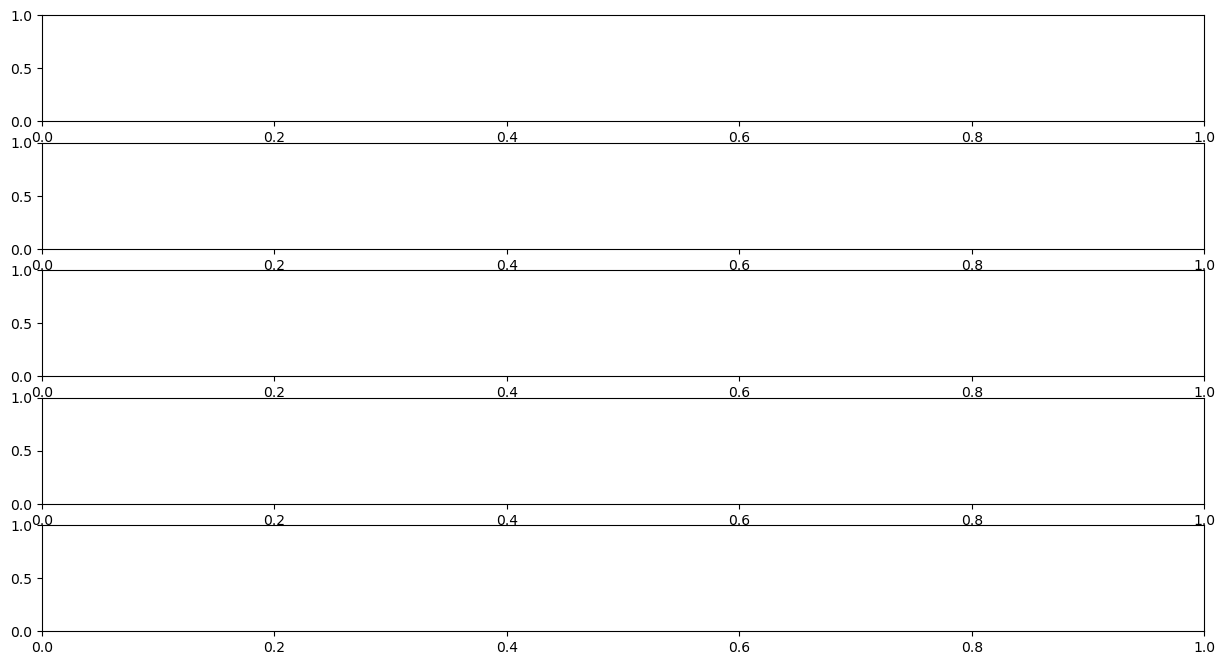

In [144]:
def __makeplot():

    Nrow, Ncol = 5, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].scatter(np.array(range(len(fs_w)))+0.5, fs_w, zorder=2)
    ax[0].scatter(np.array(range(len(fs_m)))+0.5, fs_m, zorder=2)

    ax[1].scatter(np.array(range(len(ac_w)))+0.5, ac_w, zorder=2)
    ax[1].scatter(np.array(range(len(ac_m)))+0.5, ac_m, zorder=2)

    ax[2].scatter(np.array(range(len(dc_w)))+0.5, dc_w, zorder=2)
    ax[2].scatter(np.array(range(len(dc_m)))+0.5, dc_m, zorder=2)

    ax[3].scatter(np.array(range(len(dc_w)))+0.5, ac_w/dc_w, zorder=2)
    ax[3].scatter(np.array(range(len(dc_m)))+0.5, ac_m/dc_m, zorder=2)

    ax[3].set_yscale("log")

    ax[4].scatter(np.array(range(len(ph)))+0.5, ph, zorder=2)


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].legend(loc=1)

    plt.show();
    return fig

__makeplot();

In [127]:
fs, ac, dc, ph = np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan, np.ones(len(times))*np.nan


out_df = DataFrame()
out_df['time1'] = list(zip(*times))[0]
out_df['time2'] = list(zip(*times))[1]

for _k, _st in enumerate([sagn, mon1, mon2]):

    for _n, (t1, t2) in enumerate(times):

        _dat = _st.copy().trim(t1, t2)

        f, psd = __welch_psd(_dat[0].data, _dat[0].stats.delta, twin_sec=interval)
        # f, psd = __multitaper_psd(_dat[0].data, _dat[0].stats.delta, n_win=4)

        f_pha, pha = phase_spectrum(_dat[0].data, _dat[0].stats.sampling_rate)

        fs[_n], ac[_n], dc[_n], ph[_n] = __get_values(f, psd, f_pha, pha, 303)

    if _k == 0:
        out_df['fj_fs'], out_df['fj_ac'], out_df['fj_dc'], out_df['fj_ph'] = fs, ac, dc, ph
    elif _k == 1:
        out_df['f1_fs'], out_df['f1_ac'], out_df['f1_dc'], out_df['f1_ph'] = fs, ac, dc, ph
    elif _k == 2:
        out_df['f2_fs'], out_df['f2_ac'], out_df['f2_dc'], out_df['f2_ph'] = fs, ac, dc, ph


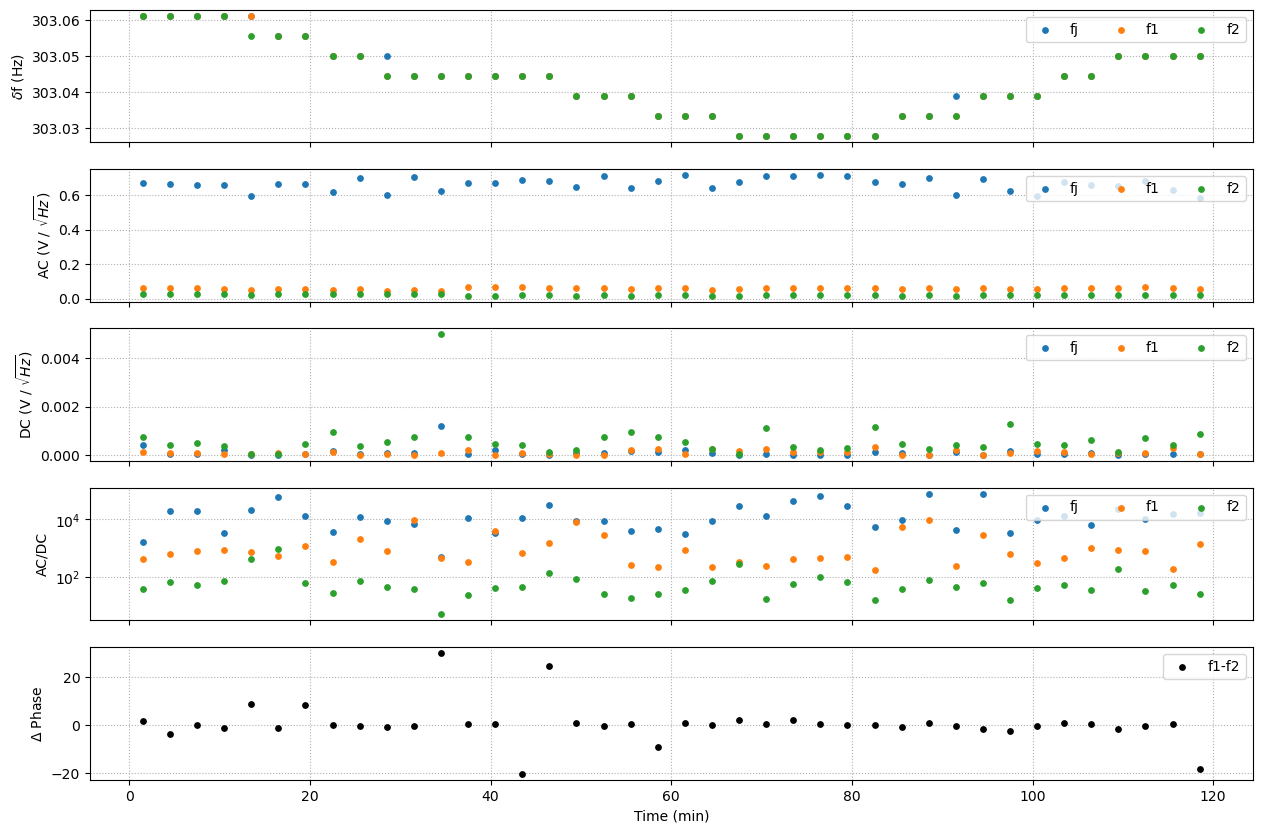

In [128]:
def __makeplot(df):

    Nrow, Ncol = 5, 1

    font = 12
    ms = 15

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    t_axis = (np.array(range(len(df['fj_fs'])))+0.5)*interval/60

    ax[0].scatter(t_axis, df['fj_fs'], zorder=2, s=ms, label="fj")
    ax[0].scatter(t_axis, df['f1_fs'], zorder=2, s=ms, label="f1")
    ax[0].scatter(t_axis, df['f2_fs'], zorder=2, s=ms, label="f2")
    ax[0].set_ylabel("$\delta$f (Hz)")
    ax[0].ticklabel_format(useOffset=False)

    ax[1].scatter(t_axis, df['fj_ac'], zorder=2, s=ms, label="fj")
    ax[1].scatter(t_axis, df['f1_ac'], zorder=2, s=ms, label="f1")
    ax[1].scatter(t_axis, df['f2_ac'], zorder=2, s=ms, label="f2")
    ax[1].set_ylabel("AC (V / $\sqrt{Hz})$")

    ax[2].scatter(t_axis, df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[2].scatter(t_axis, df['f1_dc'], zorder=2, s=ms, label="f1")
    ax[2].scatter(t_axis, df['f2_dc'], zorder=2, s=ms, label="f2")
    ax[2].set_ylabel("DC (V / $\sqrt{Hz})$")

    ax[3].scatter(t_axis, df['fj_ac']/df['fj_dc'], zorder=2, s=ms, label="fj")
    ax[3].scatter(t_axis, df['f1_ac']/df['f1_dc'], zorder=2, s=ms, label="f1")
    ax[3].scatter(t_axis, df['f2_ac']/df['f2_dc'], zorder=2, s=ms, label="f2")
    ax[3].set_yscale("log")
    ax[3].set_ylabel("AC/DC")

    ax[4].scatter(t_axis, df['f1_ph']/df['f2_ph'], color="k", zorder=2, s=ms, label="f1-f2")
    ax[4].set_ylabel("$\Delta$ Phase")

    ax[4].set_xlabel("Time (min)")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot(out_df);

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_multitaper_values.jpeg", format="jpeg", dpi=200, bbox_inches='tight')